In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [2]:
# Our hyperparams, you will be here again soon :)

NGRAM_MINIMAL_OCURRENCES=10
MAX_FEATURES = 100_000
VECTORIZER_NGRAM_RANGE=(3,4)
AUTOENCODER_TARGET_DIMENSION= 128
TRAIN_TEST_SPLIT=0.2
AUTOENCODER_LINEAR_LAYERS_DIM=256
AUTOENCODER_EMBEDDING_DIM = 64
LEARNING_RATE=1e-3
TRAINING_EPOCHS = 300
INFERENCE_THRESHOLD_PERCENTILE = 95
BATCH_SIZE=512
ENCODER_DROPOUT=0.1

# Autoencoder "bottleneck" enforcer
# Ensures the architecture compresses down to a smaller latent dim and then expands again
assert AUTOENCODER_TARGET_DIMENSION <= AUTOENCODER_LINEAR_LAYERS_DIM, \
    "Hidden layer must be >= input dim for a proper encoder expansion"
assert AUTOENCODER_EMBEDDING_DIM < min(AUTOENCODER_TARGET_DIMENSION, AUTOENCODER_LINEAR_LAYERS_DIM), \
    "Embedding dim must be smaller than both input and hidden dims (true bottleneck)"


In [3]:
# Some manual feature engineering. You can try removing it and see how the autoencoder behaves without it.
CONSONANTS_PATTERN = re.compile(r'[bcdfghjklmnpqrstvwxyz]+')

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    counts = Counter(s)
    length = len(s)
    ent = 0.0
    for c, cnt in counts.items():
        p = cnt / length
        ent -= p * math.log(p)
    return ent


def max_repeated_char_run(s: str) -> int:
    if not s:
        return 0
    max_run = 1
    cur_run = 1
    prev = s[0]
    for ch in s[1:]:
        if ch == prev:
            cur_run += 1
            if cur_run > max_run:
                max_run = cur_run
        else:
            cur_run = 1
            prev = ch
    return max_run


def longest_consonant_sequence(s: str) -> int:
    s = s.lower()
    matches = CONSONANTS_PATTERN.findall(s)
    if not matches:
        return 0
    return max(len(m) for m in matches)

def seg_features(s: str):
    segs = s.split('.') if s else ['']
    seg_lens = [len(seg) for seg in segs]
    return {
            'avg_segment_length': float(np.mean(seg_lens)) if seg_lens else 0.0,
            'tld': segs[-1] if segs else ''
    }
    
def expand_domain_features(df: pd.DataFrame, domain_col: str = 'domain') -> pd.DataFrame:
    df = df.copy()
    df['_domain_raw'] = df[domain_col].astype(str)
    df['_domain'] = df['_domain_raw'].str.strip().str.lower()
    df['total_length'] = df['_domain'].str.len()
    df['num_dots'] = df['_domain'].str.count('\.')
    df['num_dashes'] = df['_domain'].str.count('-')
    df['num_underscores'] = df['_domain'].str.count('_')
    df['num_digits'] = df['_domain'].str.count('\\d')
    segs_df = df['_domain'].apply(seg_features).apply(pd.Series)
    df = pd.concat([df, segs_df], axis=1)
    df['tld_length'] = df['tld'].str.len()
    df['entropy'] = df['_domain'].apply(shannon_entropy)
    df['longest_consonant_seq'] = df['_domain'].apply(longest_consonant_sequence)
    df['max_repeated_char_run'] = df['_domain'].apply(max_repeated_char_run)
    df = df.drop(columns=['_domain', '_domain_raw', 'tld'])

    
    return df

In [4]:
df = pd.read_csv("./output_data/filtered_mal_domains.csv", names=["domain"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,domain
0,olx.oferta-94560823.cfd
1,allegrolokalnie.oferta2281766.sbs
2,allegro.pl-oferta76507799364825-samsung-galaxy...
3,oferta-4820055.top
4,alebilet.pi-59282845.rest
...,...
35293,allegro.pl-oferta0783529.cfd
35294,allegro.pl-oferta3392937.cfd
35295,rusasu-vifeli.site
35296,allegro.pl-52148.icu


In [5]:
df_domains = df
df_domains = expand_domain_features(df_domains)
# Positional awareness hack - the TF-IDF vectorizer does not preserve order or interconnections between n-grams.
# We can at least force the creation of distinct start/end n-grams.
df_domains['domain'] = '^' + df_domains['domain'].astype(str) + '$'
df_domains

,domain,total_length,num_dots,num_dashes,num_underscores,num_digits,avg_segment_length,tld_length,entropy,longest_consonant_seq,max_repeated_char_run
0,^olx.oferta-94560823.cfd$,23,2,1,0,8,7.000000,3,2.954673,3,1
1,^allegrolokalnie.oferta2281766.sbs$,33,2,0,0,7,10.333333,3,2.818806,3,2
2,^allegro.pl-oferta76507799364825-samsung-galax...,57,2,5,0,15,18.333333,3,3.190128,3,2
3,^oferta-4820055.top$,18,1,1,0,7,8.500000,3,2.582306,2,2
4,^alebilet.pi-59282845.rest$,25,2,1,0,8,7.666667,4,2.698880,2,1
...,...,...,...,...,...,...,...,...,...,...,...
35293,^allegro.pl-oferta0783529.cfd$,28,2,1,0,7,8.666667,3,2.917433,3,2
35294,^allegro.pl-oferta3392937.cfd$,28,2,1,0,7,8.666667,3,2.750214,3,2
35295,^rusasu-vifeli.site$,18,1,1,0,0,8.500000,4,2.370135,1,1
35296,^allegro.pl-52148.icu$,20,2,1,0,5,6.000000,3,2.761626,2,2


In [6]:
# TF-IDF vectorization using VECTORIZER_NGRAM_RANGE - i.e., n-grams of length 3 and 4
numeric_domain_features = df_domains.drop('domain', axis=1)
feature_names = numeric_domain_features.columns.tolist()

ngram_vectorizer = TfidfVectorizer(
    analyzer='char', 
    ngram_range=VECTORIZER_NGRAM_RANGE, 
    min_df=NGRAM_MINIMAL_OCURRENCES, 
    max_features=MAX_FEATURES, # If memory usage is a problem, keep MAX_FEATURES lower
    lowercase=True, 
    norm="l2", 
    sublinear_tf=True
)

vectorized_domains = ngram_vectorizer.fit_transform(df_domains['domain'])
ngrams_detected = ngram_vectorizer.get_feature_names_out()


# Dimensionality reduction to match our encoder input/output size
svd_dimension_reducer = TruncatedSVD(
    n_components=AUTOENCODER_TARGET_DIMENSION-len(feature_names), 
    random_state=42
)

dense_vectorized_domains = svd_dimension_reducer.fit_transform(vectorized_domains)
domain_vectors = np.hstack([dense_vectorized_domains.astype(np.float32)])

print("Summary:")
print("n-grams used:", len(list(ngrams_detected)))
print("custom manually preprocessed features:", numeric_domain_features.shape)
print("n-grams after dimensionality reduction:", dense_vectorized_domains.shape)

Summary:
n-grams used: 17256
custom manually preprocessed features: (35298, 10)
n-grams after dimensionality reduction: (35298, 118)


In [7]:
# TF-IDF is already normalized; we should not touch it
# We need to normalize our custom features separately and combine them with our n-gram vectors
scaler = StandardScaler()
numeric_domain_features = scaler.fit_transform(numeric_domain_features)
domain_vectors = np.hstack([numeric_domain_features, domain_vectors.astype(np.float32)])
domain_vectors_scaled = domain_vectors
print("Combined preprocessed dataset:", domain_vectors.shape)

Combined preprocessed dataset: (35298, 128)


In [8]:
# We do not have labels in our unsupervised method, yet validation will be useful for checking overfitting.
domain_vectors_scaled_train_np, domain_vectors_scaled_validation_np = train_test_split(domain_vectors_scaled, test_size=TRAIN_TEST_SPLIT, random_state=42)
print(domain_vectors_scaled_train_np.shape)
print(domain_vectors_scaled_validation_np.shape)

(28238, 128)
(7060, 128)


In [9]:
# Autoencoder architecture
# The network learns to compress input data into a lower-dimensional latent space (encoder) and then reconstruct it back to the original form (decoder)
# The encoder captures the most informative features by reducing dimensionality, enabling efficient data representation and noise reduction
# The decoder forces the latent space to retain meaningful structure by reconstructing inputs accurately
# ReLU activations introduce non-linearity, allowing the model to learn complex relationships
# Dropout is applied to improve generalization and prevent overfitting during training
# The symmetry between encoder and decoder ensures balanced compression and reconstruction capabilities

class Autoencoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, AUTOENCODER_LINEAR_LAYERS_DIM),
            nn.ReLU(),
            nn.Dropout(p=ENCODER_DROPOUT),
            nn.Linear(AUTOENCODER_LINEAR_LAYERS_DIM, embed_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, AUTOENCODER_LINEAR_LAYERS_DIM),
            nn.ReLU(),
            nn.Linear(AUTOENCODER_LINEAR_LAYERS_DIM, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
# Plumbing: convert to tensors and use DataLoaders for the training loop
domain_vectors_scaled_train_tensor = torch.tensor(domain_vectors_scaled_train_np, dtype=torch.float32)
domain_vectors_scaled_validation_tensor = torch.tensor(domain_vectors_scaled_validation_np, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(domain_vectors_scaled_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(TensorDataset(domain_vectors_scaled_validation_tensor), batch_size=BATCH_SIZE, shuffle=True)

Model size: 99,008
tensor(0.0022) tensor(0.2697)
Epoch   0 | Train Loss: 0.031506 | Val Loss: 0.006582
Epoch  10 | Train Loss: 0.001662 | Val Loss: 0.001203
Epoch  20 | Train Loss: 0.001348 | Val Loss: 0.000858
Epoch  30 | Train Loss: 0.001196 | Val Loss: 0.000712
Epoch  40 | Train Loss: 0.001045 | Val Loss: 0.000591
Epoch  50 | Train Loss: 0.000967 | Val Loss: 0.000519
Epoch  60 | Train Loss: 0.000897 | Val Loss: 0.000471
Epoch  70 | Train Loss: 0.000826 | Val Loss: 0.000427
Epoch  80 | Train Loss: 0.000778 | Val Loss: 0.000404
Epoch  90 | Train Loss: 0.000730 | Val Loss: 0.000354
Epoch 100 | Train Loss: 0.000688 | Val Loss: 0.000354
Epoch 110 | Train Loss: 0.000651 | Val Loss: 0.000321
Epoch 120 | Train Loss: 0.000611 | Val Loss: 0.000294
Epoch 130 | Train Loss: 0.000581 | Val Loss: 0.000277
Epoch 140 | Train Loss: 0.000567 | Val Loss: 0.000250
Epoch 150 | Train Loss: 0.000539 | Val Loss: 0.000288
Epoch 160 | Train Loss: 0.000526 | Val Loss: 0.000239
Epoch 170 | Train Loss: 0.000506 

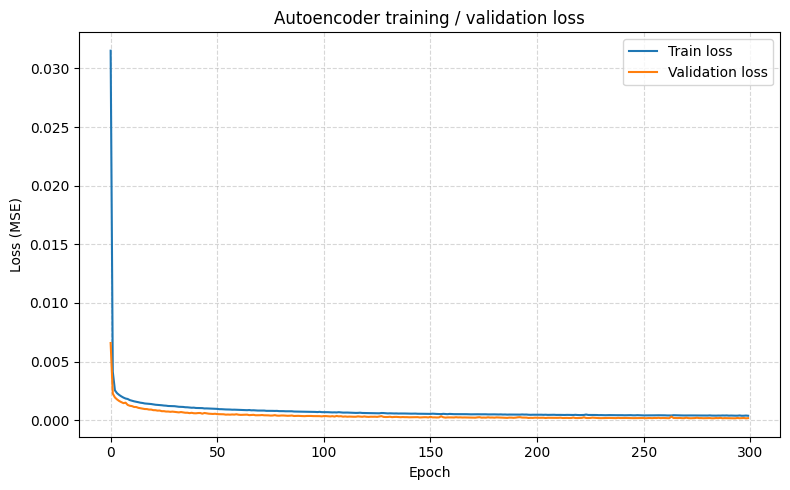

Typically, if your validation loss increases while training loss decreases, you’ve trained too long or your model is too large


In [11]:
# Model setup
# In some cases, autoencoders can have different input and output dimensions, but we’ll stick with the standard equal size.
# input_dim = domain_vectors_scaled_train_tensor.shape[1]

input_dim = AUTOENCODER_TARGET_DIMENSION
embed_dim = AUTOENCODER_EMBEDDING_DIM

model = Autoencoder(input_dim, embed_dim)
criterion = nn.MSELoss(reduction='mean')

optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE
)

# Some statistics
P = sum(p.numel() for p in model.parameters())
print(f"Model size: {P:,}")
print(domain_vectors_scaled_train_tensor.mean(), domain_vectors_scaled_train_tensor.std())

# Training loop
train_losses, val_losses = [], []

for epoch in range(TRAINING_EPOCHS):
    model.train()
    total_loss = 0.0
    for (batch,) in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (batch,) in validation_loader:
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item() * batch.size(0)
    val_loss /= len(validation_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder training / validation loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
print("Typically, if your validation loss increases while training loss decreases, you’ve trained too long or your model is too large")

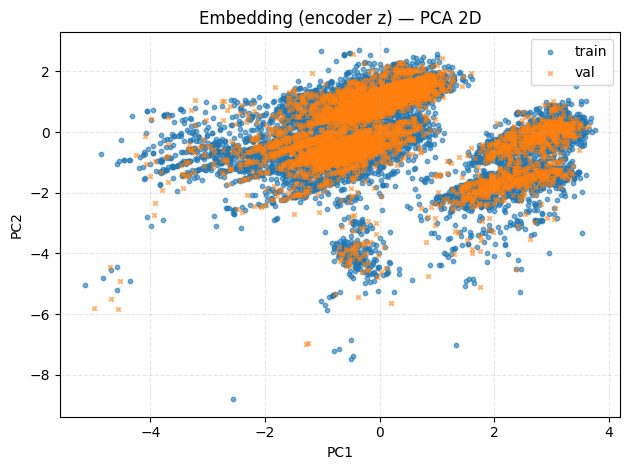

In [12]:
# A nice feature of the autoencoder is that we can apply PCA to its embeddings and try to infer what the autoencoder has learned.

# Interpretation of PCA visualization on train/validation embeddings

# In each case, train and validation embeddings should overlap. If they don't, the autoencoder may overfit or encode dataset-specific features

# You have two (or more) compact clusters of points:
#  The autoencoder has learned some structure in the data
#  Each "island" likely represents a region of the latent space corresponding to different types of input examples (e.g., different semantic groups, domains, or token patterns)

# You have a single (preferably symmetric) cluster of points:
#   The autoencoder generalizes well and encodes the data into a smooth, continuous latent space.

# You observe elongated or stripe-like distributions of points:
#  The latent space may have one or more dominant directions of variance
#  This can indicate that the encoder compresses data mostly along one latent axis (e.g., one dimension strongly correlates with input scale or intensity)
#  If the stripes are parallel and distinct, it may suggest quantization effects or that the network uses discrete-like latent features rather than continuous ones. 
#  The autoencoder isn’t truly categorical, but certain latent dimensions may activate only for specific input patterns, behaving like feature presence indicators rather than smooth numeric encodings

# You have a large, diffuse scatter of points without clear structure:
#  The autoencoder may not have learned a meaningful latent representation yet
#  Possible causes: undertraining, too much dropout, or too high learning rate



model.eval()
with torch.no_grad():
    embeddings_train = model.encoder(domain_vectors_scaled_train_tensor).numpy()
    embeddings_validation = model.encoder(domain_vectors_scaled_validation_tensor).numpy()

pca = PCA(n_components=2, random_state=42)
P_train = pca.fit_transform(embeddings_train)
P_val   = pca.transform(embeddings_validation)

plt.figure()
plt.scatter(P_train[:,0], P_train[:,1], s=10, label="train", alpha=0.6)
plt.scatter(P_val[:,0],   P_val[:,1],   s=10, label="val",   alpha=0.6, marker='x')
plt.title("Embedding (encoder z) — PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
def domain_to_features(domain: str):
    df_domains = expand_domain_features(pd.DataFrame({'domain': [domain]}))
    numeric_domain_features = df_domains.drop('domain', axis=1)    
    # Remember n-gram positional trick?
    X = ngram_vectorizer.transform(['^' + domain + "$"])
    X = svd_dimension_reducer.transform(X)
    Z = scaler.transform(numeric_domain_features)
    domain_vector = np.hstack([Z, X.astype(np.float32)])    
    return domain_vector.astype(np.float32)

@torch.no_grad()
def reconstruction_error(domain: str) -> float:
    model.eval()
    X = domain_to_features(domain)
    x = torch.from_numpy(X)
    x_hat = model(x)
    mse = torch.mean((x - x_hat)**2).item()
    return mse

In [14]:
@torch.no_grad()
def reconstruction_error_batch(domains: list[str]) -> np.ndarray:
    df_domains = expand_domain_features(pd.DataFrame({'domain': domains}))
    numeric_domain_features = df_domains.drop('domain', axis=1)
    model.eval()
    # Remember n-gram positional trick?
    domains = list(map(lambda d: '^' + d + '$', domains))
    X = ngram_vectorizer.transform(domains)
    X = svd_dimension_reducer.transform(X)
    Z = scaler.transform(numeric_domain_features)
    
    domain_vector = np.hstack([Z, X.astype(np.float32)])    
    x = torch.from_numpy(domain_vector.astype(np.float32))
    x_hat = model(x)
    mse = torch.mean((x - x_hat)**2, dim=1).cpu().numpy()
    return mse

In [15]:
# Raw inference tests

test_domains = [
    "allegro.pl-oferta9372.icu",
    "augustyniak.pl",
    "google.pl",
    "vinted.pl-oferta1292136.icu",
    "alebilet.pl-oferta1292136.icu",
    "001gameapp6.com",
    "presentations.ai",
    "01lx.8618421.xyz",
    "allegrolokalnie.kategorie-inne-283831.sbs"
]
for td in test_domains:
    err = reconstruction_error(td)
    print(td, "reconstruction MSE:", f"{err:.6f}")
print("BATCH", "#" * 20)

batch_res = reconstruction_error_batch(test_domains)
print(batch_res)
print(np.min(batch_res))

allegro.pl-oferta9372.icu reconstruction MSE: 0.000148
augustyniak.pl reconstruction MSE: 0.000973
google.pl reconstruction MSE: 0.001829
vinted.pl-oferta1292136.icu reconstruction MSE: 0.000046
alebilet.pl-oferta1292136.icu reconstruction MSE: 0.000041
001gameapp6.com reconstruction MSE: 0.001492
presentations.ai reconstruction MSE: 0.001117
01lx.8618421.xyz reconstruction MSE: 0.000237
allegrolokalnie.kategorie-inne-283831.sbs reconstruction MSE: 0.000152
BATCH ####################
[1.4784685e-04 9.7251270e-04 1.8291743e-03 4.6442277e-05 4.1183572e-05
 1.4916433e-03 1.1167900e-03 2.3701845e-04 1.5157335e-04]
4.118357e-05


Tau (95 pct): 0.000376122


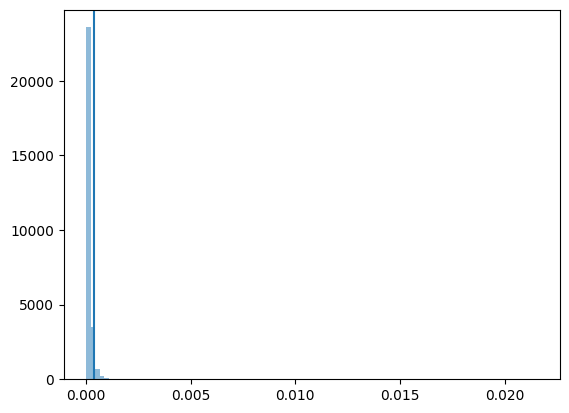

In [16]:
# Selecting tau is conceptually similar to choosing an operating point on a ROC/PR curve:
# although ROC is not explicitly computed, adjusting tau controls the sensitivity–specificity balance.
# In a well-trained autoencoder, reconstruction errors should concentrate near zero with a short right tail;
# a pronounced right tail often indicates underfitting, data heterogeneity, or the presence of outliers in training data.

model.eval()
train_mse = []
with torch.no_grad():
    for (batch,) in DataLoader(TensorDataset(domain_vectors_scaled_train_tensor),
                               batch_size=BATCH_SIZE, shuffle=False):
        out = model(batch)
        mse = torch.mean((batch - out) ** 2, dim=1)
        train_mse.append(mse.cpu().numpy())
train_mse = np.concatenate(train_mse)

# You can change the percentile to get better specificity or accuracy
tau = np.percentile(train_mse, INFERENCE_THRESHOLD_PERCENTILE) 
 # You can manually tweak your tau threshold to get better specificity or accuracy; it's more fine-grained than changing the percentile.
tau = 0.9 * tau

print("Tau ({} pct): {:.6g}".format(INFERENCE_THRESHOLD_PERCENTILE, tau))
plt.hist(train_mse, bins=100, alpha=0.5); plt.axvline(tau)


def is_similar_to_known_phish(domain: str) -> bool:
    err = reconstruction_error(domain)
    return err <= tau, err

In [17]:
# Let's save all the parts needed for the eventual inference-only script
model_bundle = {
    "ngram_vectorizer": ngram_vectorizer,
    "svd_dimension_reducer": svd_dimension_reducer,
    "model": model,
    "scaler" : scaler,
    "tau" : tau
}

with open("./output_data/phish_autoencoder.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

In [18]:
# Let's do some testing on phishing domains never seen before and some legitimate domains from the Majestic dataset
mal_domains = pd.read_csv("./output_data/new_mal_domains.csv")
SAMPLE_SIZE = mal_domains.shape[0]

mal_domains = mal_domains.sample(SAMPLE_SIZE, replace=False)
mal_domains = list(mal_domains[mal_domains.columns[0]])



mal_domains_reconstruction_errors = reconstruction_error_batch(mal_domains)
mal_domains_reconstruction_errors_median = np.median(mal_domains_reconstruction_errors)
misclassified = np.sum(mal_domains_reconstruction_errors > tau)
print("Median reconstruction error for phishing domains:", mal_domains_reconstruction_errors_median)
print("Misclassified:", misclassified, "out of", SAMPLE_SIZE, "phishing domains", (misclassified / SAMPLE_SIZE) * 100, "%")

print("#" * 80)

legit_domains = pd.read_csv("./input_data/majestic_million.csv")
legit_domains = legit_domains.sample(SAMPLE_SIZE)
legit_domains = list(legit_domains[legit_domains.columns[2]])

legit_domains_reconstruction_errors = reconstruction_error_batch(legit_domains)
legit_domains_reconstruction_errors_median = np.median(legit_domains_reconstruction_errors)
misclassified = np.sum(legit_domains_reconstruction_errors <= tau)
print("Median reconstruction error for legitimate domains:", legit_domains_reconstruction_errors_median)
print("Misclassified:", misclassified, "out of", SAMPLE_SIZE, "legitimate domains",  (misclassified / SAMPLE_SIZE) * 100, "%")

print("#" * 80)

print(is_similar_to_known_phish("pagedout.institute"))
print(is_similar_to_known_phish("allegro.pl"))
print(is_similar_to_known_phish("alleg-ropl.icu"))

# for ld in legit_domains:
#     sim = is_similar_to_known_phish(ld)
#     if sim[0]:
#         print(ld, sim)
        
    



Median reconstruction error for phishing domains: 0.000114592505
Misclassified: 290 out of 3922 phishing domains 7.394186639469659 %
################################################################################
Median reconstruction error for legitimate domains: 0.0012522121
Misclassified: 723 out of 3922 legitimate domains 18.434472208057116 %
################################################################################
(False, 0.0033355806954205036)
(False, 0.029454292729496956)
(True, 0.0003212539304513484)
